In [3]:
spark

In [4]:
infile = 'file:///home/cloudera/2.kkbox_churn/raw_data/transactions_v1+v2'
df0 = spark.read.format('csv').option('header','true').load(infile)
df0.printSchema()

root
 |-- msno: string (nullable = true)
 |-- payment_method_id: string (nullable = true)
 |-- payment_plan_days: string (nullable = true)
 |-- plan_list_price: string (nullable = true)
 |-- actual_amount_paid: string (nullable = true)
 |-- is_auto_renew: string (nullable = true)
 |-- transaction_date: string (nullable = true)
 |-- membership_expire_date: string (nullable = true)
 |-- is_cancel: string (nullable = true)



In [8]:
df0.groupBy('msno').count().count()
# number of members:

2426143

# plan_days = 0

In [5]:
from pyspark.sql.functions import col
df1 = df0.where(col('payment_plan_days') == '0') \
         .where(col('is_cancel') == '0')

In [6]:
from pyspark.sql.functions import max
df1.select(max('transaction_date')).show()

+---------------------+
|max(transaction_date)|
+---------------------+
|             20151223|
+---------------------+



In [8]:
df1.groupBy('msno').count().count()
# number of members with a record with plan_days = 0 and is_cancel = 0

492895

In [3]:
df_actual_paid_q = df1.groupBy('actual_amount_paid').count().persist()
df_actual_paid_q.show(40)

+------------------+------+
|actual_amount_paid| count|
+------------------+------+
|               447|    33|
|               894|  3573|
|              1788|  3947|
|                35|   482|
|                 0|  8181|
|              2000|     4|
|               300|   168|
|               100|   697|
|               596|    21|
|               131|   198|
|              1000|    33|
|              1200|    45|
|               799|   202|
|               450|    46|
|               350|    19|
|               536|  1299|
|               150| 13363|
|              1599|   623|
|               500|    26|
|               930|    39|
|               480|   193|
|               134|  1055|
|               149|766669|
|              1150|     2|
|               105|    26|
|               400|     9|
|               129| 27048|
|                50|     5|
|               119| 26130|
+------------------+------+



## trying to guess plan_days from plan_list_price
Use only data with trans_date <= 20151231.

In [2]:
from pyspark.sql.functions import col
df2 = df0.where(col('transaction_date') < '20160101') \
         .where(col('plan_list_price') != '0')
df2.count()

7485781

In [7]:
# payment_plan_days vs. plan_list_price 
df3 = df2.groupBy('plan_list_price', 'payment_plan_days').count().persist()
df3.orderBy('plan_list_price', 'payment_plan_days').show()

+---------------+-----------------+-------+
|plan_list_price|payment_plan_days|  count|
+---------------+-----------------+-------+
|              1|               90|      6|
|             10|                2|     21|
|            100|               30|  11520|
|           1000|              200|    456|
|            105|               21|    353|
|           1150|              230|     72|
|            119|               30|  25858|
|            120|               30|    164|
|           1200|              360|   3692|
|            124|               30|    598|
|            126|               30|    137|
|            129|               30| 505864|
|            131|               30|     61|
|            134|               30|   2109|
|            143|               30|      1|
|            149|               30|5258923|
|            149|               31| 766612|
|            149|               35|    320|
|             15|                3|     19|
|            150|               

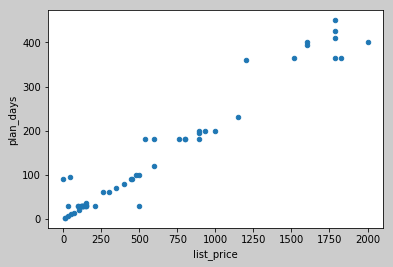

In [6]:
import matplotlib.pyplot as plt
fig = plt.figure(facecolor='#cccccc')
ax = fig.add_subplot(1, 1, 1)

df3.selectExpr('CAST(plan_list_price AS int) AS list_price',
               'CAST(payment_plan_days AS int) AS plan_days')\
   .toPandas().plot(ax=ax, kind='scatter', x='list_price', y='plan_days')

plt.show()

In [11]:
from pyspark.sql.functions import max
df4 = df3.groupBy('plan_list_price').agg(max('count').alias('max_count')) \
      .withColumnRenamed('plan_list_price', 'plan_list_price_')
df4.show()

+----------------+---------+
|plan_list_price_|max_count|
+----------------+---------+
|             800|        7|
|             124|      598|
|             447|     1216|
|              15|       19|
|              30|        7|
|             894|    63054|
|            1788|    68228|
|              35|     4017|
|            2000|      101|
|              99|   487536|
|             300|     2807|
|             100|    11520|
|              70|       29|
|            1520|       13|
|             596|       27|
|             131|       61|
|             126|      137|
|             120|      164|
|            1000|      456|
|            1200|     3692|
+----------------+---------+
only showing top 20 rows



In [19]:
df5 = df3.join(df4, 
               [df3['plan_list_price']==df4['plan_list_price_'],
                df3['count']==df4['max_count']]
              ) \
      .select('plan_list_price', 'payment_plan_days') 
df5.sort(col('plan_list_price').cast('int')).show(40)

+---------------+-----------------+
|plan_list_price|payment_plan_days|
+---------------+-----------------+
|              1|               90|
|             10|                2|
|             15|                3|
|             30|               30|
|             35|                7|
|             44|               95|
|             50|               10|
|             70|               14|
|             99|               30|
|            100|               30|
|            105|               21|
|            119|               30|
|            120|               30|
|            124|               30|
|            126|               30|
|            129|               30|
|            131|               30|
|            134|               30|
|            143|               30|
|            149|               30|
|            150|               30|
|            210|               30|
|            265|               60|
|            300|               60|
|            350|           

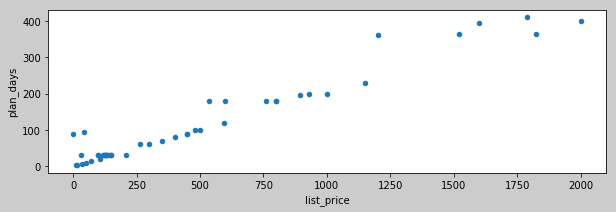

In [17]:
import matplotlib.pyplot as plt
fig = plt.figure(facecolor='#cccccc', figsize=(10,3))
ax = fig.add_subplot(1, 1, 1)

df5.selectExpr('CAST(plan_list_price AS int) AS list_price',
               'CAST(payment_plan_days AS int) AS plan_days')\
   .toPandas().plot(ax=ax, kind='scatter', x='list_price', y='plan_days')
plt.show()

In [20]:
# output
outfile = '/home/cloudera/2.kkbox_churn/data01/from_raw_transactions-v1+v2/' \
          + 'plan-days_vs_list-price'
df5.coalesce(1).write.format('csv').option('header','true') \
   .save(outfile)

In [9]:
# input
infile = '/home/cloudera/2.kkbox_churn/data01/from_raw_transactions-v1+v2/' \
          + 'plan-days_vs_list-price'
df5 = spark.read.format('csv').option('header','true').load(infile)
df5.printSchema()

root
 |-- plan_list_price: string (nullable = true)
 |-- payment_plan_days: string (nullable = true)



In [15]:
# check
df6 = df_actual_paid_q.join(df5, 
                            df_actual_paid_q['actual_amount_paid']==df5['plan_list_price'],
                            'left_outer') \
      .drop('count').drop('plan_list_price')
df6.show(40)

29
+------------------+-----------------+
|actual_amount_paid|payment_plan_days|
+------------------+-----------------+
|               447|               90|
|               894|              195|
|              1788|              410|
|                35|                7|
|                 0|             null|
|              2000|              400|
|               300|               60|
|               100|               30|
|               596|              120|
|               131|               30|
|              1000|              200|
|              1200|              360|
|               799|              180|
|               450|               90|
|               350|               70|
|               536|              180|
|               150|               30|
|              1599|              395|
|               500|              100|
|               930|              200|
|               480|              100|
|               134|               30|
|               149|  

## actual_paid = 0

In [8]:
from pyspark.sql.functions import col
df2 = df1.where(col('actual_amount_paid') == '0')
df2.count()

8181

In [9]:
df2.groupBy('msno').count().count()
# number of members with a record with plan_days = 0, is_cancel = 0, and actual_paid = 0:

8163

# is_cancel = 1 but is_auto_renew = 0

In [12]:
df1 = df0.where('is_cancel == 1').where('is_auto_renew == 0') \
      .select('msno','transaction_date', 'membership_expire_date').persist()
df1.show()

+--------------------+----------------+----------------------+
|                msno|transaction_date|membership_expire_date|
+--------------------+----------------+----------------------+
|iFbwtXr/IkqQz2GNq...|        20150917|              20150914|
|CXFw603gL/79Sd2l/...|        20150424|              20150422|
|Eh3+liOO4bPSZABm1...|        20151003|              20150929|
|tGPeF1ZQnR0G8F7cu...|        20160920|              20160913|
|5zw+P3gUDvX3hPlv4...|        20150429|              20150427|
|YK0mAbVp4I452/awL...|        20150308|              20150308|
|/Nel+muc1PTxTHDep...|        20170116|              20170111|
|YK0mAbVp4I452/awL...|        20160121|              20160120|
|bXVpyDYBw/e4k92ZG...|        20161128|              20161115|
|hPTUSf0yN5su3crCq...|        20150415|              20150515|
+--------------------+----------------+----------------------+



In [14]:
df0.join(df1, df0['msno']==df1['msno'], 'left_semi') \
  .select('msno', 'transaction_date', 'is_auto_renew', 'is_cancel') \
  .sort('msno', 'transaction_date').show()
# the records of the members who have a record with is_cancel=1 and is_auto_renew=0:

+--------------------+----------------+-------------+---------+
|                msno|transaction_date|is_auto_renew|is_cancel|
+--------------------+----------------+-------------+---------+
|/Nel+muc1PTxTHDep...|        20170116|            0|        1|
|5zw+P3gUDvX3hPlv4...|        20150429|            0|        1|
|CXFw603gL/79Sd2l/...|        20150424|            0|        1|
|Eh3+liOO4bPSZABm1...|        20151003|            0|        1|
|YK0mAbVp4I452/awL...|        20150308|            0|        1|
|YK0mAbVp4I452/awL...|        20150316|            0|        0|
|YK0mAbVp4I452/awL...|        20160121|            0|        1|
|bXVpyDYBw/e4k92ZG...|        20161128|            0|        1|
|hPTUSf0yN5su3crCq...|        20150131|            0|        0|
|hPTUSf0yN5su3crCq...|        20150228|            0|        0|
|hPTUSf0yN5su3crCq...|        20150331|            0|        0|
|hPTUSf0yN5su3crCq...|        20150415|            0|        1|
|iFbwtXr/IkqQz2GNq...|        20150917| 